In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import m2cgen as m2c
import joblib
import pickle
import glob
import sys
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

print("done")



done


In [3]:
files = glob.glob("clean_csv/*.csv")
print(files)
for file in files:
    print(file.split("\\")[1])

['clean_csv\\in01-bus-window.csv', 'clean_csv\\in02-in-takapuna-library-children.csv', 'clean_csv\\in03-in-takapuna-library-general.csv', 'clean_csv\\in04-classroom.csv', 'clean_csv\\in05-in-building-by-window1150.csv', 'clean_csv\\out01-cbd-walk.csv', 'clean_csv\\out02-walk-primary.csv', 'clean_csv\\out03-park.csv', 'clean_csv\\out04-tree-shade.csv', 'clean_csv\\out05-walk-primary.csv', 'clean_csv\\out06-out-takapuna-cbd.csv', 'clean_csv\\out07-cbd-walk-1619.csv', 'clean_csv\\out08-cbd-walk-1240.csv', 'clean_csv\\out09-albert-park-1421.csv', 'clean_csv\\out10-cbd-walk-1258.csv', 'clean_csv\\out11-under-clear-ceiling-1308.csv', 'clean_csv\\out12-walk-afterschool.csv', 'clean_csv\\out13-walk-toschool.csv']
in01-bus-window.csv
in02-in-takapuna-library-children.csv
in03-in-takapuna-library-general.csv
in04-classroom.csv
in05-in-building-by-window1150.csv
out01-cbd-walk.csv
out02-walk-primary.csv
out03-park.csv
out04-tree-shade.csv
out05-walk-primary.csv
out06-out-takapuna-cbd.csv
out07-cb

# Preprocessing



In [3]:
# Import data to use as training data

dataframes_in = []
dataframes_out = []
files = glob.glob("clean_csv/*.csv")
print(files)
for filename in files:
    df = pd.read_csv(filename,  index_col=False)
    print(df.head())
    print(filename[10])
    if filename[10] == "i":
        print("in")
        dataframes_in.append(df)
    else:
        print("out")
        dataframes_out.append(df)

in_data = pd.concat(dataframes_in)
out_data = pd.concat(dataframes_out)


['clean_csv\\in01-bus-window.csv', 'clean_csv\\in02-in-takapuna-library-children.csv', 'clean_csv\\in03-in-takapuna-library-general.csv', 'clean_csv\\in04-classroom.csv', 'clean_csv\\in05-in-building-by-window1150.csv', 'clean_csv\\out01-cbd-walk.csv', 'clean_csv\\out02-walk-primary.csv', 'clean_csv\\out03-park.csv', 'clean_csv\\out04-tree-shade.csv', 'clean_csv\\out05-walk-primary.csv', 'clean_csv\\out06-out-takapuna-cbd.csv', 'clean_csv\\out07-cbd-walk-1619.csv', 'clean_csv\\out08-cbd-walk-1240.csv', 'clean_csv\\out09-albert-park-1421.csv', 'clean_csv\\out10-cbd-walk-1258.csv', 'clean_csv\\out11-under-clear-ceiling-1308.csv', 'clean_csv\\out12-walk-afterschool.csv', 'clean_csv\\out13-walk-toschool.csv']
    timestamp  uv  accelX  accelY  accelZ    r    g    b     c  colorTemp  \
0  1712470902   0    -487    1873    6644  127  142  175   356       7404   
1  1712470906   0   -1746   -1469    8748  335  501  464  1319       6668   
2  1712470908   1   -2418     295    8408   67  113  1

C:\Users\lucia\AppData\Local\Temp\ipykernel_25376\1508858384.py:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename,  index_col=False)


In [4]:
# Outdoors is positive
print(in_data.shape)
print(out_data.shape)
in_data["target"] = 0
out_data["target"] = 1

all_data = pd.concat([in_data, out_data])

(1506, 12)
(2915, 12)


In [19]:
all_data.head()

,timestamp,uv,accelX,accelY,accelZ,r,g,b,c,colorTemp,lux,target
0,1.712471e+09,0,-487,1873,6644,127,142,175,356,7404,54,0
1,1.712471e+09,0,-1746,-1469,8748,335,501,464,1319,6668,342,0
2,1.712471e+09,1,-2418,295,8408,67,113,118,298,8101,70,0
3,1.712471e+09,0,-1215,-245,7452,9,11,12,25,7106,5,0
4,1.712471e+09,0,-3068,-286,6818,31,37,39,78,6993,19,0


In [26]:
print(all_data["target"].value_counts())




target
1    2915
0    1506
Name: count, dtype: int64


# Create new features

In [5]:
import math
# accelerometer

all_data['accelN'] = all_data.apply(lambda row: (row.accelX + row.accelY + row.accelZ) / 3, axis=1)
all_data['accelMagnitude'] = all_data.apply(lambda row: row.accelX ** 2 + row.accelY ** 2 + row.accelZ ** 2, axis=1)
all_data['accelXY'] = all_data.apply(lambda row: (row.accelX * row.accelY) ** 2, axis=1)


# rgb vs clear
all_data['red/clear'] = all_data.apply(lambda row: row.r / (row.c + 1), axis=1)
all_data['green/clear'] = all_data.apply(lambda row: row.g /  (row.c + 1), axis=1)
all_data['blue/clear'] = all_data.apply(lambda row: row.b /  (row.c + 1), axis=1)

# rgb versus each other
all_data['red/green'] = all_data.apply(lambda row: row.r / (row.g + 1), axis=1)
all_data['blue/red'] = all_data.apply(lambda row: row.g / (row.r + 1), axis=1)
all_data['blue/green'] = all_data.apply(lambda row: row.b / (row.g + 1), axis=1)

# relative difference of each colour compared to rgbc channels
all_data["(clear-red)/red"] = all_data.apply(lambda row: (row.c - row.r) / (row.r + 1), axis=1)
all_data["(clear-green)/red"] = all_data.apply(lambda row: (row.c - row.g) / (row.r + 1), axis=1)
all_data["(clear-blue)/red"] = all_data.apply(lambda row: (row.c - row.b) / (row.r + 1), axis=1)

all_data["(clear-red)/green"] = all_data.apply(lambda row: (row.c - row.r) / (row.g + 1), axis=1)
all_data["(clear-green)/green"] = all_data.apply(lambda row: (row.c - row.g) / (row.g + 1), axis=1)
all_data["(clear-blue)/green"] = all_data.apply(lambda row: (row.c - row.b) / (row.g + 1), axis=1)

all_data["(clear-red)/blue"] = all_data.apply(lambda row: (row.c - row.r) / (row.b + 1), axis=1)
all_data["(clear-green)/blue"] = all_data.apply(lambda row: (row.c - row.g) / (row.b + 1), axis=1)
all_data["(clear-blue)/blue"] = all_data.apply(lambda row: (row.c - row.b) / (row.b + 1), axis=1)

all_data["(clear-red)/clear"] = all_data.apply(lambda row: (row.c - row.r) / (row.c + 1), axis=1)
all_data["(clear-green)/clear"] = all_data.apply(lambda row: (row.c - row.g) / (row.c + 1), axis=1)
all_data["(clear-blue)/clear"] = all_data.apply(lambda row: (row.c - row.b) / (row.c + 1), axis=1)


# rgb vs clear
all_data['red/clear'] = all_data.apply(lambda row: row.r / (row.c + 1), axis=1)
all_data['green/clear'] = all_data.apply(lambda row: row.g /  (row.c + 1), axis=1)
all_data['blue/clear'] = all_data.apply(lambda row: row.b /  (row.c + 1), axis=1)


# log(rgb) vs log(clear)
all_data['log(red)/log(clear)'] = all_data.apply(lambda row: math.log(row.r + 1)/ math.log(row.c + 1), axis=1)
all_data['log(green)/log(clear)'] = all_data.apply(lambda row: math.log(row.g + 1) / math.log(row.c + 1), axis=1)
all_data['log(blue)/log(clear)'] = all_data.apply(lambda row: math.log(row.b + 1) / math.log(row.c + 1), axis=1)

#difference between clear and rgb
all_data['log(red)/log(clear)'] = all_data.apply(lambda row: math.log(row.r + 1)/ math.log(row.c + 1), axis=1)


#log(rgb) versus each other
all_data['log(red)/log(green)'] = all_data.apply(lambda row: math.log(row.r + 1) / math.log(row.g + 1), axis=1)
all_data['log(blue)/log(red)'] = all_data.apply(lambda row: math.log(row.g + 1) / math.log(row.r + 1), axis=1)
all_data['log(blue)/log(green)'] = all_data.apply(lambda row: math.log(row.b + 1) / math.log(row.g + 1), axis=1)

# sqrt(rgb) vs sqrt(clear)
all_data['sqrt(red)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.r + 1)/ math.sqrt(row.c + 1), axis=1)
all_data['sqrt(green)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.g + 1) / math.sqrt(row.c + 1), axis=1)
all_data['sqrt(blue)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.b + 1) / math.sqrt(row.c + 1), axis=1)

#sqrt(rgb) vs each other
all_data['sqrt(red)/sqrt(green)'] = all_data.apply(lambda row: math.sqrt(row.r + 1) / math.sqrt(row.g + 1), axis=1)
all_data['sqrt(blue)/sqrt(red)'] = all_data.apply(lambda row: math.sqrt(row.g + 1) / math.sqrt(row.r + 1), axis=1)
all_data['sqrt(blue)/sqrt(green)'] = all_data.apply(lambda row: math.sqrt(row.b + 1) / math.sqrt(row.g + 1), axis=1)


# uv vs lux
all_data['uv/lux'] = all_data.apply(lambda row: row.lux / (row.c + 1), axis=1)
all_data['e^(uv/lux)'] = all_data.apply(lambda row: math.exp (row.lux / (row.c + 1)), axis=1)




In [7]:
X_train = all_data.drop(['timestamp', 'target'], axis=1)
y_train = all_data['target']
column_names = list(X_train.columns)

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 512, test_size=0)
# column_names = list(X.columns)
# print(X_train.head())
# print(column_names)

# Useful functions and values for final evaluation

In [7]:
#initializing useful lists
accuracies = {"Test": {}, "Train": {}}
precisions = {"Test": {}, "Train": {}}
recall = {"Test": {}, "Train": {}}
f_score = {"Test": {}, "Train": {}}

def set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name):
    test_precision, test_recall, test_f_score, _ = precision_recall_fscore_support(y_test, test_predictions)
    train_precision, train_recall, train_f_score, _ = precision_recall_fscore_support(y_train, train_predictions)


    print(name, 1 - test_precision, 1 - test_recall, 1 - test_f_score)
    print(name, 1 - train_precision, 1 - train_recall, 1 - train_f_score)

    precisions["Test"][name] = test_precision
    precisions["Train"][name] = train_precision

    recall["Test"][name] = test_recall
    recall["Train"][name] = train_recall

    f_score["Test"][name] = test_f_score
    f_score["Train"][name] = train_f_score

def set_accuracies(name, train_accuracy, test_accuracy):
    accuracies["Train"][name] = train_accuracy
    accuracies["Test"][name] = test_accuracy


# Classifiers

In [16]:

from xgboost import XGBClassifier, plot_importance

xgboost_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}


xgb_model = XGBClassifier(random_state = 42)
xgb_grid_search = GridSearchCV(xgb_model, xgboost_param_grid, scoring='roc_auc', cv=5)
xgb_grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'subsample': [0.5, 0.7, 1]},
             scoring='roc_auc')

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1}
Best score:  0.9264742951837036


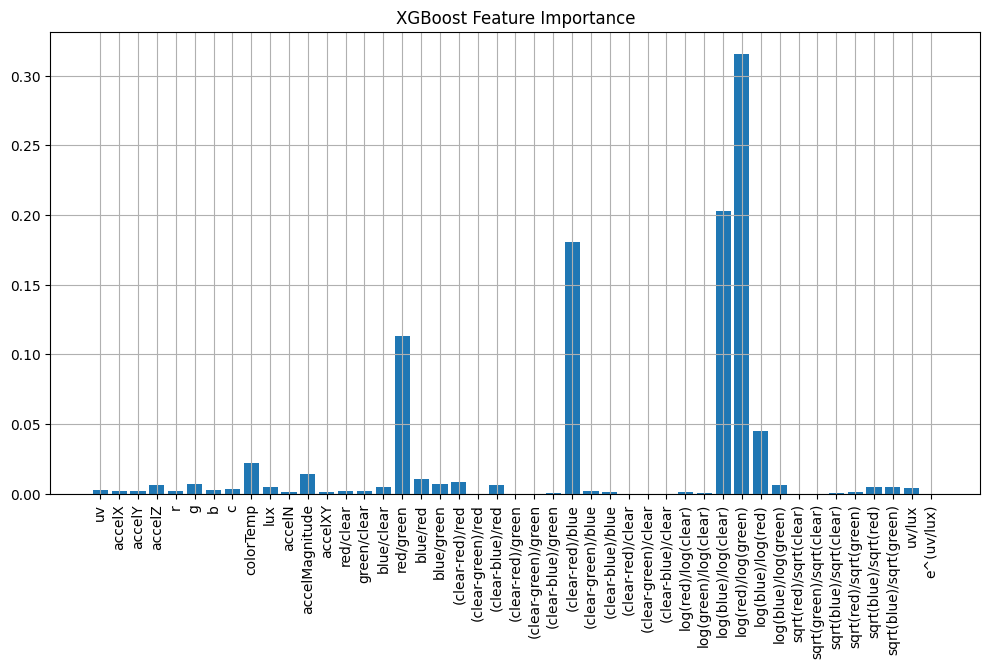

uv: 0.003
accelY: 0.002
accelZ: 0.006
g: 0.007
b: 0.002
c: 0.003
colorTemp: 0.022
lux: 0.005
accelMagnitude: 0.014
blue/clear: 0.005
red/green: 0.113
blue/red: 0.011
blue/green: 0.007
(clear-red)/red: 0.009
(clear-blue)/red: 0.006
(clear-red)/blue: 0.181
(clear-green)/blue: 0.002
log(blue)/log(clear): 0.203
log(red)/log(green): 0.316
log(blue)/log(red): 0.045
log(blue)/log(green): 0.006
sqrt(blue)/sqrt(red): 0.005
sqrt(blue)/sqrt(green): 0.005
uv/lux: 0.004


In [18]:

print("Best set of hyperparameters: ", xgb_grid_search.best_params_)
print("Best score: ", xgb_grid_search.best_score_)

feature_importances = xgb_grid_search.best_estimator_.feature_importances_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importance")
plt.grid()
plt.show()

for feature, importance in zip(column_names, feature_importances):
    if importance > 0.002:
        print(f"{feature}: {importance:.3f}")



In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



adaboost_model = AdaBoostClassifier(DecisionTreeClassifier())

adb_param_grid = {'estimator__max_depth':[2, 4],
              'estimator__min_samples_leaf':[10, 20],
              'n_estimators':[10,50,100],
              }

adaboost_grid_search = GridSearchCV(adaboost_model, adb_param_grid, scoring='roc_auc', cv=5)
adaboost_grid_search.fit(X_train, y_train) 

c:\Users\lucia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lucia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lucia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lucia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__max_depth': [2, 4],
                         'estimator__min_samples_leaf': [10, 20],
                         'n_estimators': [10, 50, 100]},
             scoring='roc_auc')

Best set of hyperparameters:  {'estimator__max_depth': 4, 'estimator__min_samples_leaf': 10, 'n_estimators': 50}
Best score:  0.9432191522259492


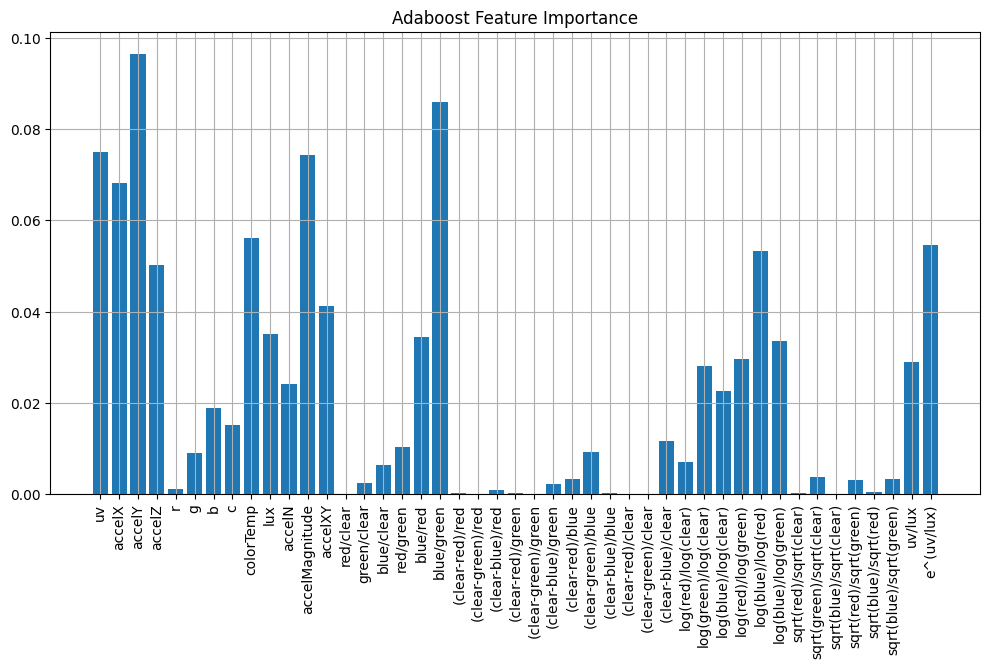

uv: 0.075
accelX: 0.068
accelY: 0.097
accelZ: 0.050
g: 0.009
b: 0.019
c: 0.015
colorTemp: 0.056
lux: 0.035
accelN: 0.024
accelMagnitude: 0.074
accelXY: 0.041
green/clear: 0.002
blue/clear: 0.006
red/green: 0.010
blue/red: 0.034
blue/green: 0.086
(clear-blue)/green: 0.002
(clear-red)/blue: 0.003
(clear-green)/blue: 0.009
(clear-blue)/clear: 0.012
log(red)/log(clear): 0.007
log(green)/log(clear): 0.028
log(blue)/log(clear): 0.023
log(red)/log(green): 0.030
log(blue)/log(red): 0.053
log(blue)/log(green): 0.034
sqrt(green)/sqrt(clear): 0.004
sqrt(red)/sqrt(green): 0.003
sqrt(blue)/sqrt(green): 0.003
uv/lux: 0.029
e^(uv/lux): 0.055


In [26]:

print("Best set of hyperparameters: ", adaboost_grid_search.best_params_)
print("Best score: ", adaboost_grid_search.best_score_)

feature_importances = adaboost_grid_search.best_estimator_.feature_importances_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.title("Adaboost Feature Importance")
plt.grid()
plt.show()

for feature, importance in zip(column_names, feature_importances):
    if importance > 0.002:
        print(f"{feature}: {importance:.3f}")



In [14]:
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 300]
}


rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid,scoring='roc_auc', cv=5)

rf_grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 300]},
             scoring='roc_auc')

Best set of hyperparameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.9529329287684438


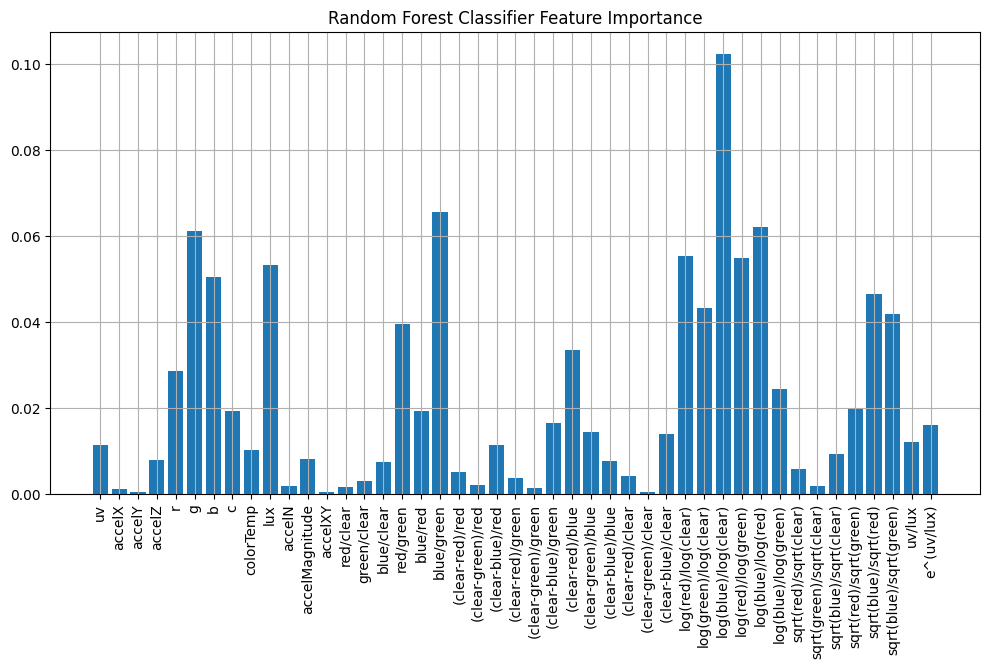

r: 0.029
g: 0.061
b: 0.050
lux: 0.053
red/green: 0.039
blue/green: 0.066
(clear-red)/blue: 0.033
log(red)/log(clear): 0.055
log(green)/log(clear): 0.043
log(blue)/log(clear): 0.102
log(red)/log(green): 0.055
log(blue)/log(red): 0.062
log(blue)/log(green): 0.024
sqrt(blue)/sqrt(red): 0.046
sqrt(blue)/sqrt(green): 0.042


In [17]:

print("Best set of hyperparameters: ", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_)

feature_importances = rf_grid_search.best_estimator_.feature_importances_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.title("Random Forest Classifier Feature Importance")
plt.grid()
plt.show()

for feature, importance in zip(column_names, feature_importances):
    if importance > 0.03:
        print(f"{feature}: {importance:.3f}")



In [30]:


nb_model = GaussianNB()
# nb_model.fit(X_train, y_train)

nb_scores = cross_val_score(nb_model, X_train, y_train, cv = 5, scoring = 'roc_auc')
nb_cv_avg = np.mean(nb_scores)

print("Best score: ", nb_cv_avg)

Best score:  0.5556499501300725


In [7]:
# SVM Linear
from sklearn.svm import SVC

svm_param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [10, 1, 0.1, 0.01],} 

svm_model = SVC(kernel='linear')
svm_grid_linear = GridSearchCV(svm_model, svm_param_grid, cv = 5, refit = True)
svm_grid_linear.fit(X_train, y_train)



In [ ]:

print("Best set of hyperparameters: ", svm_grid_linear.best_params_)
print("Best score: ", svm_grid_linear.best_score_)

feature_importances = svm_grid_linear.best_estimator_.coef_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.title("Linear Feature Importance")
plt.grid()
plt.show()


In [ ]:
# SVM RBF
from sklearn.svm import SVC

svm_param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [10, 1, 0.1, 0.01]} 

svm_model = SVC(kernel='rbf')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv = 5, refit = True)
svm_grid.fit(X_train, y_train)


print("Best set of hyperparameters: ", svm_param_grid.best_params_)
print("Best score: ", svm_param_grid.best_score_)

feature_importances = xgb_grid_search.best_estimator_.coef_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.grid()
plt.show()


In [ ]:
# SVM Poly
from sklearn.svm import SVC

svm_param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [10, 1, 0.1, 0.01], 
              'kernel': ['rbf', "linear", "poly"]} 

svm_model = SVC(kernel='poly')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv = 5, refit = True)
svm_grid.fit(X_train, y_train)


print("Best set of hyperparameters: ", svm_param_grid.best_params_)
print("Best score: ", svm_param_grid.best_score_)

feature_importances = xgb_grid_search.best_estimator_.coef_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.grid()
plt.show()


In [23]:
# SVM RBF with removing features
from sklearn.svm import SVC
X_train_reduced = X_train[["red/green", "(clear-red)/blue", "log(blue)/log(clear)", "log(red)/log(green)", "log(blue)/log(green)"]]
svm_param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [10, 1, 0.1, 0.01]} 

svm_model = SVC(kernel='rbf')
svm_grid_reduction = GridSearchCV(svm_model, svm_param_grid, cv = 5, refit = True)
svm_grid_reduction.fit(X_train_reduced, y_train)




GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01]})

In [24]:

print("Best set of hyperparameters: ", svm_grid_reduction.best_params_)
print("Best score: ", svm_grid_reduction.best_score_)

# feature_importances = svm_grid_reduction.best_estimator_.coef_

# fig = plt.figure(figsize=(12,6))
# plt.bar(column_names, feature_importances)
# plt.xticks(rotation=90)
# plt.title("RBF SVM Feature Importance")
# plt.grid()
# plt.show()

Best set of hyperparameters:  {'C': 100, 'gamma': 10}
Best score:  0.9330352532147149


In [30]:
# SVM RBF with removing features
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf')
X_train_reduced_02 = X_train[["r", "g" , "b", "lux", "red/green", "blue/green","(clear-red)/blue", "log(red)/log(clear)", "log(green)/log(clear)", "log(blue)/log(clear)", "log(red)/log(green)", "log(blue)/log(red)","log(blue)/log(green)", "sqrt(blue)/sqrt(red)", "sqrt(blue)/sqrt(green)"]]
svm_param_grid_02 = {'C': [ 0.1, 1, 10, 50],  
              'gamma': [0.0001, 0.00001]} 

svm_model = SVC(kernel='rbf')
svm_grid_reduction_02 = GridSearchCV(svm_model, svm_param_grid_02, cv = 5, refit = True)
svm_grid_reduction_02.fit(X_train_reduced_02, y_train)




GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 50], 'gamma': [0.0001, 1e-05]})

In [31]:

print("Best set of hyperparameters: ", svm_grid_reduction_02.best_params_)
print("Best score: ", svm_grid_reduction_02.best_score_)

# feature_importances = svm_grid_reduction.best_estimator_.coef_

# fig = plt.figure(figsize=(12,6))
# plt.bar(column_names, feature_importances)
# plt.xticks(rotation=90)
# plt.title("RBF SVM Feature Importance")
# plt.grid()
# plt.show()

Best set of hyperparameters:  {'C': 10, 'gamma': 0.0001}
Best score:  0.9045259094511338


In [33]:
# SVM RBF with removing features
from sklearn.svm import SVC
rf_threshold_03 = ["g", "b", "lux", "red/green",  "blue/green", "(clear-red)/blue", "log(red)/log(clear)", "log(green)/log(clear)", "log(blue)/log(clear)", "log(red)/log(green)",  "log(blue)/log(red)","sqrt(blue)/sqrt(red)", "sqrt(blue)/sqrt(green)"]
X_train_reduced = X_train[["g", "b", "lux", "red/green",  "blue/green", "(clear-red)/blue", "log(red)/log(clear)", "log(green)/log(clear)", "log(blue)/log(clear)", "log(red)/log(green)",  "log(blue)/log(red)","sqrt(blue)/sqrt(red)", "sqrt(blue)/sqrt(green)"]]
svm_param_grid_03 = {'C': [0.1, 1, 10, 100],  
              'gamma': [10, 1, 0.1, 0.01]} 

svm_model = SVC(kernel='rbf')
svm_grid_reduction = GridSearchCV(svm_model, svm_param_grid_03, cv = 5, refit = True)
svm_grid_reduction.fit(X_train_reduced, y_train)




GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01]})

In [35]:

print("Best set of hyperparameters: ", svm_grid_reduction.best_params_)
print("Best score: ", svm_grid_reduction.best_score_)

# feature_importances = svm_grid_reduction.best_estimator_.coef_

# fig = plt.figure(figsize=(12,6))
# plt.bar(column_names, feature_importances)
# plt.xticks(rotation=90)
# plt.title("RBF SVM Feature Importance")
# plt.grid()
# plt.show()

Best set of hyperparameters:  {'C': 10, 'gamma': 0.01}
Best score:  0.8920924406268375


# Benchmarks
Comparing tables that compare the Accuracy, Precision and Recall of the different models.

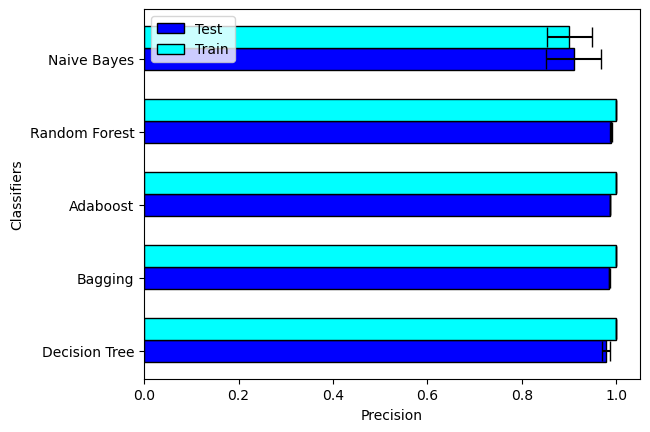

{'Test': {'Decision Tree': array([0.98648649, 0.96956522]), 'Bagging': array([0.9833887 , 0.98666667]), 'Adaboost': array([0.98666667, 0.98672566]), 'Random Forest': array([0.98671096, 0.99111111]), 'Naive Bayes': array([0.85174419, 0.96703297])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99893162, 1.        ]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99893162, 1.        ]), 'Naive Bayes': array([0.85338346, 0.94736842])}}


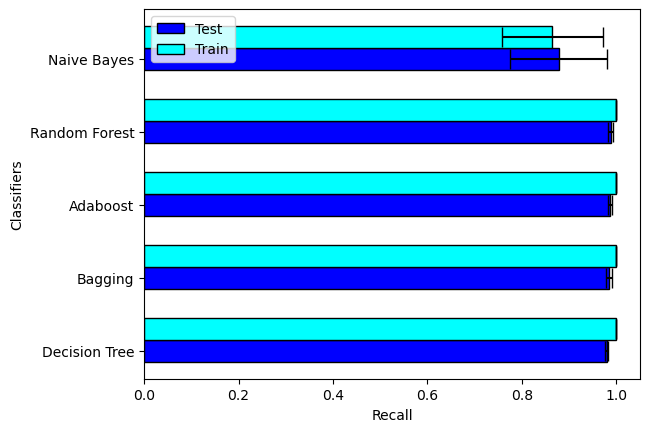

{'Test': {'Decision Tree': array([0.97658863, 0.98237885]), 'Bagging': array([0.98996656, 0.97797357]), 'Adaboost': array([0.98996656, 0.98237885]), 'Random Forest': array([0.99331104, 0.98237885]), 'Naive Bayes': array([0.97993311, 0.7753304 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([1.        , 0.99844237]), 'Adaboost': array([1., 1.]), 'Random Forest': array([1.        , 0.99844237]), 'Naive Bayes': array([0.97112299, 0.75700935])}}


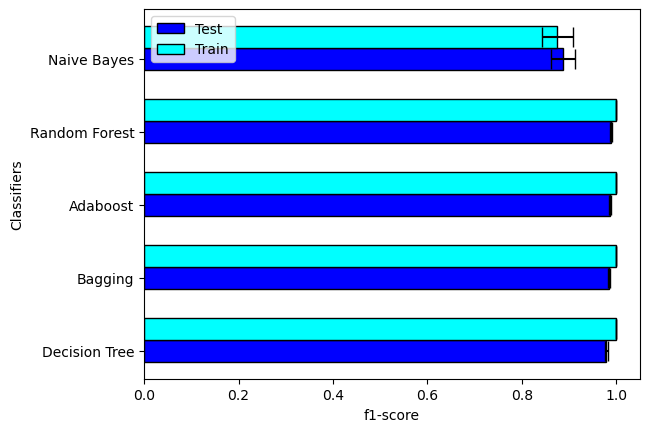

{'Test': {'Decision Tree': array([0.98151261, 0.97592998]), 'Bagging': array([0.98666667, 0.98230088]), 'Adaboost': array([0.98831386, 0.98454746]), 'Random Forest': array([0.99      , 0.98672566]), 'Naive Bayes': array([0.91135303, 0.8606357 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99946553, 0.99922058]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99946553, 0.99922058]), 'Naive Bayes': array([0.90845423, 0.84155844])}}


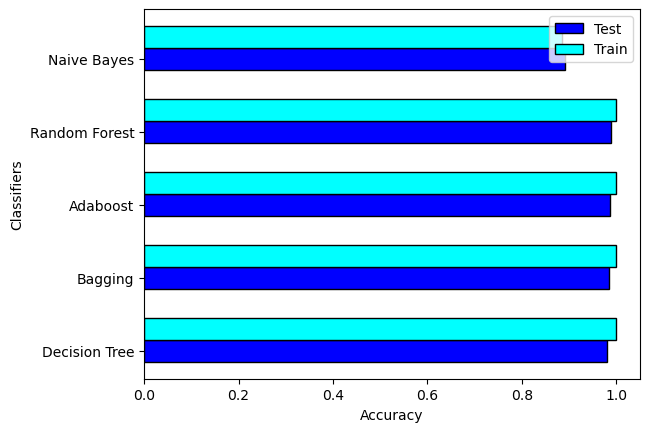

{'Test': {'Decision Tree': 0.9790874524714829, 'Bagging': 0.9847908745247148, 'Adaboost': 0.9866920152091255, 'Random Forest': 0.9885931558935361, 'Naive Bayes': 0.8916349809885932}, 'Train': {'Decision Tree': 1.0, 'Bagging': 0.9993658845909955, 'Adaboost': 1.0, 'Random Forest': 0.9993658845909955, 'Naive Bayes': 0.8839568801521877}}


In [13]:
def draw_table_w_conf_int(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())
    test_exp = []
    test_err = []
    for test_result in test_results:
        test_exp.append(test_result[0] + (test_result[1] - test_result[0]) / 2)
        test_err.append(abs(test_result[1] - test_result[0]) / 2)

    train_exp = []
    train_err = []
    for train_result in train_results:
        train_exp.append(train_result[0] + (train_result[1] - train_result[0]) / 2)
        train_err.append(abs(train_result[1] - train_result[0]) / 2)
    
    r1 = np.arange(len(test_exp))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_exp, height = bar_width, color = 'blue', edgecolor = 'black', xerr=test_err, capsize=7, label="Test")

    plt.barh(r2, train_exp, height = bar_width, color = 'cyan', edgecolor = 'black', xerr=train_err, capsize=7, label='Train')

    plt.yticks([r for r in range(len(test_exp))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()


def draw_table(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())

    
    r1 = np.arange(len(classifiers))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_results, height = bar_width, color = 'blue', edgecolor = 'black', capsize=7, label="Test")

    plt.barh(r2, train_results, height = bar_width, color = 'cyan', edgecolor = 'black', capsize=7, label='Train')

    plt.yticks([r for r in range(len(classifiers))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()

    """
    classifiers = list(data.keys())
    results = list(data.values())
    print(classifiers, results)

    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.barh(classifiers, results, color ="navy")
    
    
    plt.ylabel("Classifier")
    plt.title(f"Comparing 1 - (The {statistic}) With Each Classifier For {datatype} Data")
    plt.show()"""

draw_table_w_conf_int(precisions, "Precision")
print(precisions)

draw_table_w_conf_int(recall, "Recall")
print(recall)

draw_table_w_conf_int(f_score, "f1-score")
print(f_score)

draw_table(accuracies, "Accuracy")
print(accuracies)





    

## ROC Curve

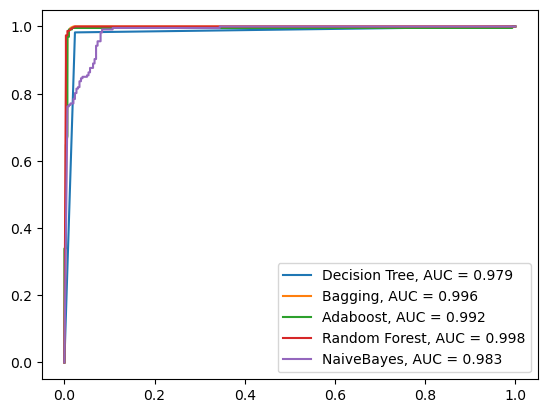

In [14]:
plt.figure(0).clf()

classifiers = {
    "Decision Tree": dTree,
    # "XGBoost": xgbClassifier,
    "Bagging": bagging,
    "Adaboost": adaboost,
    "Random Forest": random_forest,
    "NaiveBayes": naive_bayes
}

for name, classifier in classifiers.items():
    y_pred_probs = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    auc = roc_auc_score(y_test, y_pred_probs)
    plt.plot(fpr, tpr, label = f"{name}, AUC = {auc:.3f}")


plt.legend()

In [12]:
# m2cgen

dart_model = []

# naive_bayes_dart = m2c.export_to_dart(naive_bayes)
# random_forest_dart = m2c.export_to_dart(random_forest)
# xgbClassifier_dart = m2c.export_to_dart(xgbClassifier)
# adaboost_dart = m2c.export_to_dart(adaboost)

# with open('random_forest.dart', 'w') as f:
#     code = m2c.export_to_dart(random_forest)
#     f.write(code)
# with open('xgboost.dart', 'w') as f:
#     code = m2c.export_to_dart(xgbClassifier)
#     f.write(code)
# with open('xgboost.py', 'w') as f:
#     code = m2c.export_to_python(xgbClassifier)
#     f.write(code)
# with open('decision_tree.dart', 'w') as f:
#     code = m2c.export_to_dart(dTree)
#     f.write(code)
# import pickle



# with open('xgboost.pkl', 'wb') as file:

#     pickle.dump(xgbClassifier, file )



joblib.dump(xgbClassifier, "xgboost_model.pkl")

['xgboost_model.pkl']

In [13]:
# joblib.dump(x_train.columns, 'column_order.txt')